# **Read Dataset**

In [105]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting default visual style
# Instead of 'white', use 'classic' which is a built-in style
plt.style.use('classic')
# Apply the 'whitegrid' style from seaborn
sns.set_style("whitegrid")

# Load dataset
file_path = '/content/drive/MyDrive/DATASET PROJECT"/data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Tampilkan 5 data teratas
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Data Cleaning**

In [107]:
# Cek info awal
df.info()

# Ubah InvoiceDate menjadi datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Buat kolom TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Hapus baris dengan CustomerID kosong
df.dropna(subset=['CustomerID'], inplace=True)

# Hapus transaksi retur (InvoiceNo diawali "C")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Hapus data dengan Quantity dan UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Reset index
df.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **EDA(Exploratory Data Analysis)**

Analisis Penjualan

Total Sales: £8,911,407.90


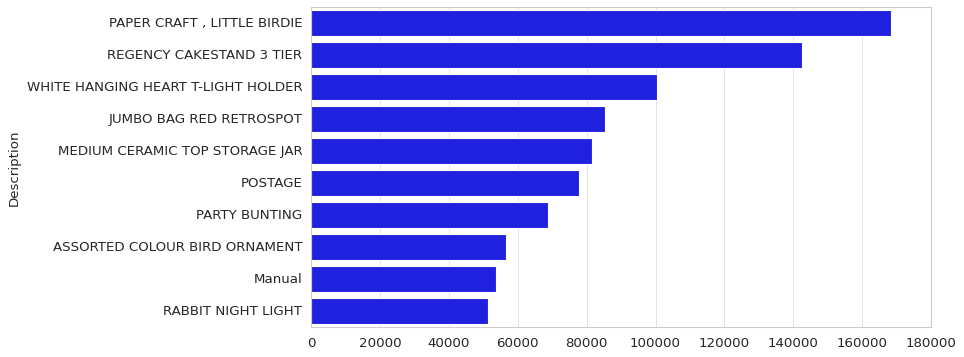

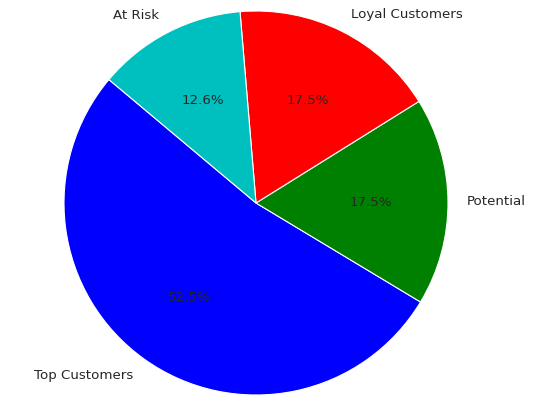

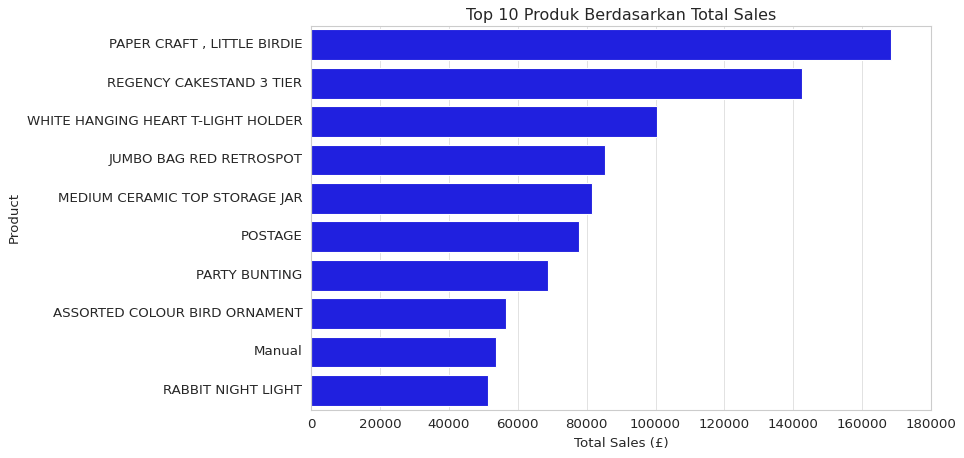

In [108]:
# Total penjualan keseluruhan
total_sales = df['TotalPrice'].sum()
print(f"Total Sales: £{total_sales:,.2f}")

# Produk terlaris berdasarkan revenue
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Visualisasi produk terlaris
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Produk Berdasarkan Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product')
plt.show()

Time Analysis

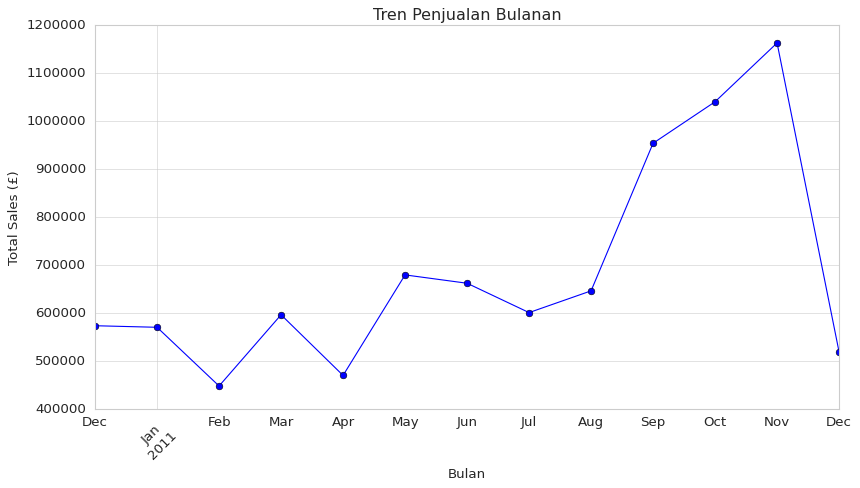

In [109]:
# Tambahkan kolom bulan dan tahun
df['Month'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('Month')['TotalPrice'].sum()

# Visualisasi tren penjualan bulanan
plt.figure(figsize=(12,6))
monthly_sales.plot(marker='o')
plt.title('Tren Penjualan Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.show()

# **RFM Analysis (Recency, Frequency, Monetary)**

Specify the reference date (e.g. last day of data + 1)

In [110]:
# Tanggal referensi: hari setelah transaksi terakhir
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

Calculate RFM Value per CustomerID

In [111]:
# Hitung RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# Rename kolom
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Lihat sample
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


Create an RFM Score (1–5) using quantiles

In [112]:
# Skor Recency (semakin rendah recency → skor tinggi)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Skor Frequency & Monetary (semakin tinggi → skor tinggi)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Gabungkan skor jadi segmen
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115,7
1,12347.0,2,7,4310.00,5,5,5,555,15
2,12348.0,75,4,1797.24,2,4,4,244,10
3,12349.0,19,1,1757.55,4,1,4,414,9
4,12350.0,310,1,334.40,1,1,2,112,4


Create Customer Segmentation

In [113]:
# Segmentasi sederhana berdasarkan RFM_Score
def segment_customer(score):
    if score >= 9:
        return 'Top Customers'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Lihat jumlah pelanggan per segmen
rfm['Segment'].value_counts()

,count
Segment,
Top Customers,2277
Potential,759
Loyal Customers,757
At Risk,545


Segmentation Visualization

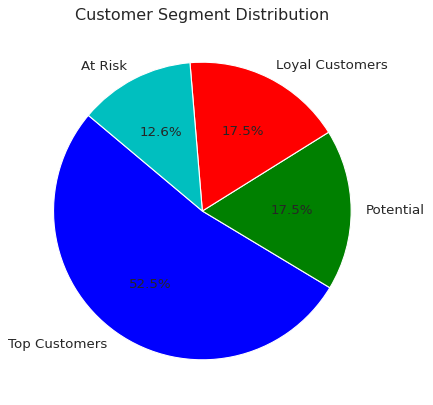

In [114]:
# Pie chart segmentasi
plt.figure(figsize=(6,6))
rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Customer Segment Distribution')
plt.ylabel('')
plt.show()

# Simpan hasil cleaning dan RFM ke file CSV
df.to_csv('cleaned_data.csv', index=False)
rfm.to_csv('rfm_segment.csv', index=False)

# **In-depth analysis for each customer segment based on RFM results**

Number of Customers per Segment

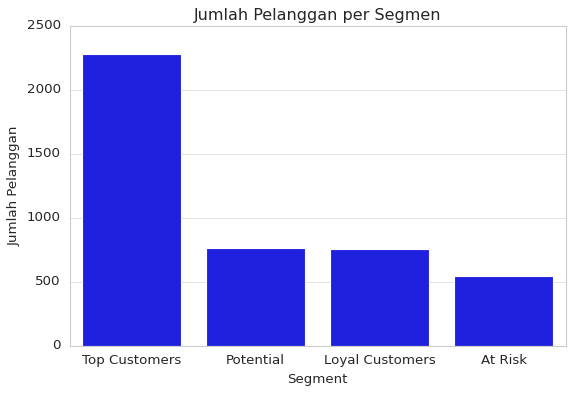

In [115]:
# Hitung jumlah pelanggan di tiap segmen
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'CustomerCount']

# Visualisasi
plt.figure(figsize=(8,5))
sns.barplot(data=segment_counts, x='Segment', y='CustomerCount')
plt.title('Jumlah Pelanggan per Segmen')
plt.xlabel('Segment')
plt.ylabel('Jumlah Pelanggan')
plt.show()

Total Revenue per Segment

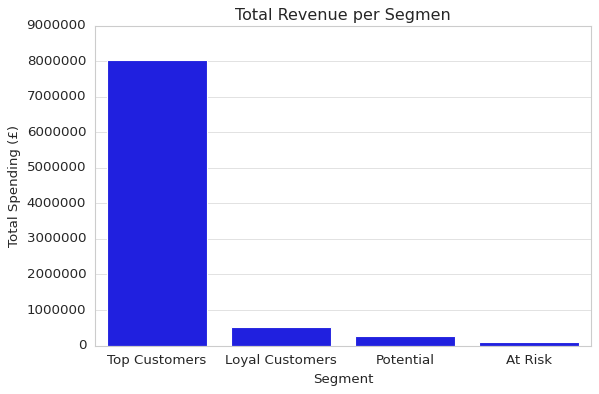

In [116]:
# Hitung total revenue dari tiap segmen
revenue_per_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=revenue_per_segment, x='Segment', y='Monetary')
plt.title('Total Revenue per Segmen')
plt.xlabel('Segment')
plt.ylabel('Total Spending (£)')
plt.show()

Average RFM per Segment

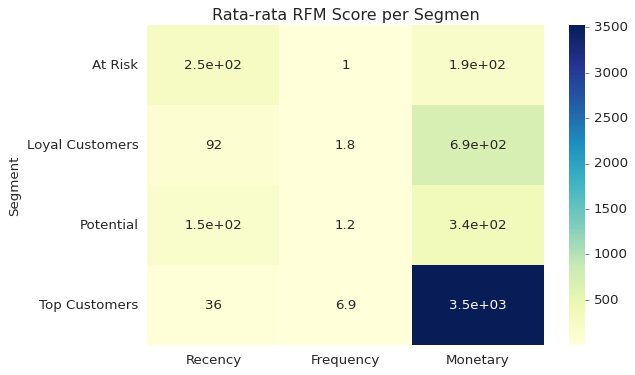

In [117]:
# Rata-rata Recency, Frequency, Monetary per segmen
rfm_mean = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Heatmap untuk melihat pola per segmen
plt.figure(figsize=(8,5))
sns.heatmap(rfm_mean, annot=True, cmap='YlGnBu')
plt.title('Rata-rata RFM Score per Segmen')
plt.show()

# **Dashboard**

In [118]:
!pip install streamlit pyngrok


In [122]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="Retail Dashboard", layout="wide")

# Fungsi untuk load CSV dari Google Drive
def load_from_gdrive(file_id, parse_dates=None):
    url = f"https://drive.google.com/uc?id={file_id}"
    return pd.read_csv(url, parse_dates=parse_dates)

# Load data dari Google Drive
df = load_from_gdrive("1_zEIUvWkEo53Ejzdr4zhB4O8U76vhMmN", parse_dates=['InvoiceDate'])
rfm = load_from_gdrive("1lhBDx7Wk_6btlPQ4b1K80ZvQRJ0XaF8G")

st.title("🛍️ Retail Sales Dashboard")

# KPI Metrics
total_sales = df['TotalPrice'].sum()
total_customers = df['CustomerID'].nunique()

col1, col2 = st.columns(2)
col1.metric("💰 Total Sales", f"£{total_sales:,.0f}")
col2.metric("👥 Total Customers", total_customers)

st.markdown("---")

# 📅 Sales Trend
df['Month'] = df['InvoiceDate'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('Month')['TotalPrice'].sum().reset_index()

st.subheader("📈 Sales Trend per Month")
st.line_chart(monthly_sales.rename(columns={'Month': 'index'}).set_index('index'))

# 🛒 Top Products
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

st.subheader("🏆 Top 10 Best-Selling Products")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_products.values, y=top_products.index, ax=ax)
st.pyplot(fig)

# 🎯 Customer Segmentation
st.subheader("🎯 Customer Segmentation (RFM)")

segment_counts = rfm['Segment'].value_counts()

fig2, ax2 = plt.subplots()
ax2.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
st.pyplot(fig2)

# 🔍 Customer Table by Segment
selected_segment = st.selectbox("Pilih Segment", rfm['Segment'].unique())
st.dataframe(rfm[rfm['Segment'] == selected_segment])

Writing app.py


In [123]:
!ngrok config add-authtoken YOUR_AUTHTOKEN_HERE

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [124]:
!ngrok config add-authtoken 2vSASR0GlYNqNASEy3rsuDpBCpN_DYEhW2sQcZLD8PKkaXSD

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [125]:
tunnel_to_close = "https://f9ab-34-73-201-123.ngrok-free.app"


In [126]:
tunnel_to_close = "https://f9ab-34-73-201-123.ngrok-free.app"


In [127]:
from pyngrok import ngrok

# Tutup semua tunnel aktif
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    ngrok.disconnect(tunnel.public_url)
    print(f"Disconnected: {tunnel.public_url}")

# Jalankan streamlit dan buat tunnel baru
!streamlit run app.py &> logs.txt &
public_url = ngrok.connect(addr='8501')
print(f"New public URL: {public_url}")


Disconnected: https://68bc-34-73-201-123.ngrok-free.app
New public URL: NgrokTunnel: "https://1ae6-34-73-201-123.ngrok-free.app" -> "http://localhost:8501"


In [128]:
%%writefile requirements.txt
streamlit
pandas
matplotlib
seaborn


Writing requirements.txt
